In [1]:
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))


import importlib, numpy as np
from sys import path
import time
import os.path
import pickle

from sunpy.map import Map
from sunpy.net import Fido,attrs as a, vso
from sunpy.time import TimeRange
from ndcube import NDCube, NDCubeSequence, NDCollection
from astropy import wcs

import astropy.units as u
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18}) # Make the fonts in figures big enough for papers
plt.rcParams.update({'figure.figsize':[27,15]})
plt.rcParams.update({'image.origin':'lower'})
np.set_printoptions(linewidth=128)

base_path = "../"
emtk_path = base_path+'code/'
path.append(emtk_path)

#import EMToolKit
#importlib.reload(EMToolKit.visualization.dashboard)

import EMToolKit.EMToolKit as emtk
from EMToolKit.visualization.dashboard import dashboard_figure
from EMToolKit.instruments.aia import load_from_paths, aia_wrapper
from EMToolKit.algorithms.sparse_em_wrapper import sparse_em_wrapper
from EMToolKit.algorithms.simple_reg_dem_wrapper import simple_reg_dem_wrapper

#jupyter nbextension enable --py widgetsnbextension

In [2]:
import EMToolKit
import EMToolKit.visualization
importlib.reload(EMToolKit)
importlib.reload(EMToolKit.visualization)
importlib.reload(EMToolKit.visualization.dashboard)
import EMToolKit.EMToolKit as emtk
from EMToolKit.visualization.dashboard import dashboard_figure
em_collection=0

In [3]:
xlen = 512*0.6*u.arcsec # 125*u.arcsec # X size of FOV in arcseconds
ylen = 512*0.6*u.arcsec # 175*u.arcsec # Y size of FOV in arcseconds
xl = -300*u.arcsec # Left edge of FOV in arcseconds (relative to disk center)
yl = -425*u.arcsec # Right edge of FOV in arcseconds (relative to disk center)

xlen = 400*0.6*u.arcsec # 125*u.arcsec # X size of FOV in arcseconds
ylen = 400*0.6*u.arcsec # 175*u.arcsec # Y size of FOV in arcseconds
xl = -0*u.arcsec # Left edge of FOV in arcseconds (relative to disk center)
yl = -0*u.arcsec # Right edge of FOV in arcseconds (relative to disk center)

sdo_data_dir = base_path+"data/20120711/" # Place to put data files. You'll need to change it or create these subdirectories
# Example data to load. We'll use a part of the field of view observed by the Hi-C rocket in 2012.
date='2012/07/11 18:54:00'
paths = [sdo_data_dir + path for path in os.listdir(sdo_data_dir)
         if (os.path.isfile(os.path.join(sdo_data_dir, path)) and ".fits" in path)]
print(f"Searching for images from {date}...")


redownload = False
if len(paths) == 0 or redownload:
# Commands for initial data download. Comment out once that's successful.
# VSO can sometimes be a bit flakey here, in my experience, may require multiple tries:
    dl_paths = []
    passbands = np.array([94,131,171,193,211,335])*u.angstrom

    # Combine the wavelength queries using the | operator
    wavelength_query = a.Wavelength(passbands[0])
    for band in passbands[1:]:
        wavelength_query |= a.Wavelength(band)

    qry = Fido.search(a.Time(TimeRange(date,12*u.s)),a.Instrument('AIA'),wavelength_query)

    print("Downloading images...")
    Fido.fetch(qry,path=sdo_data_dir, max_conn=len(passbands))

paths = [sdo_data_dir + path for path in os.listdir(sdo_data_dir)
         if (os.path.isfile(os.path.join(sdo_data_dir, path)) and ".fits" in path)]

print(f"Found {len(paths)} images on disk.")
# asdf= [print(x) for x in paths]


Searching for images from 2012/07/11 18:54:00...
Found 6 images on disk.


In [4]:
maps = load_from_paths(paths,xl=xl,yl=yl,dx=xlen,dy=ylen)
[maps,errs,trlogts,tresps] = aia_wrapper(maps)

[Text(0.5, 1.0, 'AIA 94 Temperature Response'),
 Text(0.5, 0, 'Temperature (dB Kelvin)'),
 Text(0, 0.5, 'Response (DN/s/(cm$^{-3})^2$/Mm)')]

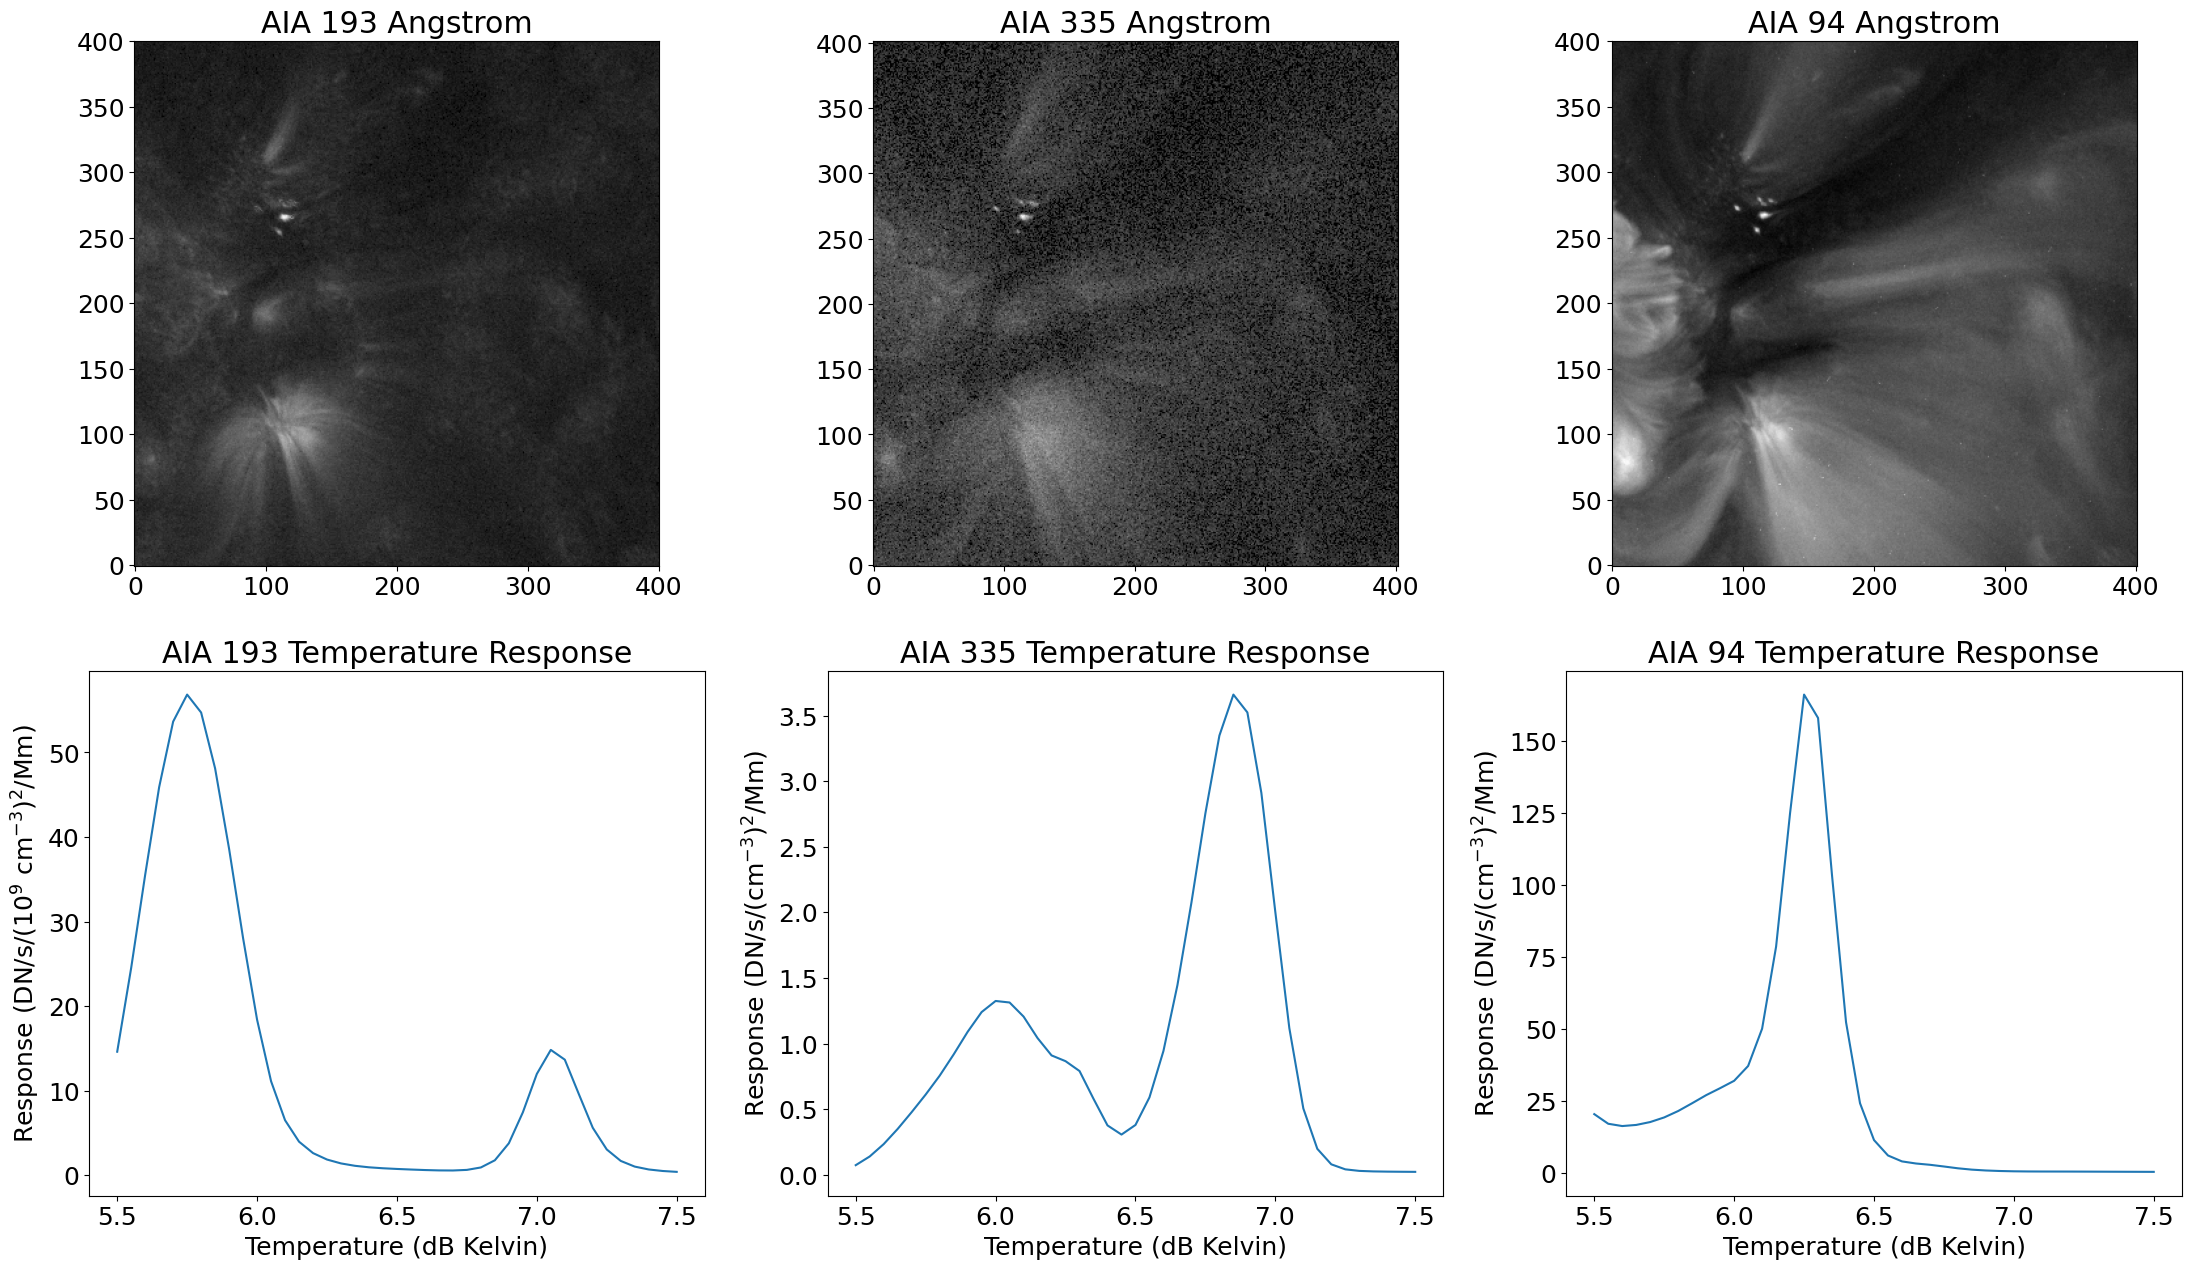

In [5]:
# Show some of the AIA channels and their temperature responses for illustration:
plt_emmax = 5.0e28
gfac = 1.0/2.2

fig, axs = plt.subplots(2, 3)
axs[0,0].imshow(np.clip(maps[1].data/np.max(tresps[1]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,0].set(title='AIA 193 Angstrom')
axs[1,0].plot(trlogts[1],tresps[1]/1.0e-27)
axs[1,0].set(title='AIA 193 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(10$^9$ cm$^{-3})^2$/Mm)')

axs[0,1].imshow(np.clip(maps[2].data/np.max(tresps[2]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,1].set(title='AIA 335 Angstrom')
axs[1,1].plot(trlogts[2],tresps[2]/1.0e-27)
axs[1,1].set(title='AIA 335 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(cm$^{-3})^2$/Mm)')

axs[0,2].imshow(np.clip(maps[5].data/np.max(tresps[5]),0,plt_emmax)**gfac,cmap=plt.get_cmap('gray'))
axs[0,2].set(title='AIA 94 Angstrom')
axs[1,2].plot(trlogts[5],tresps[5]/1.0e-27)
axs[1,2].set(title='AIA 94 Temperature Response',xlabel='Temperature (dB Kelvin)',ylabel='Response (DN/s/(cm$^{-3})^2$/Mm)')

In [6]:
# Make data sequence from AIA data:
datasequence = emtk.em_data(maps,errs,trlogts,tresps)

# Create em_collection with AIA data:
em_collection = emtk.em_collection(datasequence)

In [7]:
# Compute the DEM for Cheung et al. sparse EM method:
# Make DEM sequence from the DEM and add it to the collection:
pk_file = f'{sdo_data_dir}/sparse_em_demsequence.pkl'
# if(('sparse_em_demsequence' in locals()) == False):
recalc = False
if os.path.exists(pk_file) and not recalc:
    with open(pk_file, 'rb') as file:
        (sparse_em_demsequence, (spars_coeffs, spars_logts, spars_bases, spars_coords, spars_algorithm)) = spars_out = pickle.load(file)
else:
    tstart=time.time()
    spars_out = sparse_em_wrapper(datasequence)
    sparse_em_demsequence = emtk.dem_model(*spars_out, sparse_em_wrapper)
    print('Sparse method took',time.time()-tstart)
    with open(pk_file, 'wb') as file:
        pickle.dump((sparse_em_demsequence, spars_out), file)
    spars_coeffs, spars_logts, spars_bases, spars_coords, spars_algorithm = spars_out[1]

em_collection.add_model(sparse_em_demsequence)

In [8]:
# 'sparse_em_demsequence' in locals()
# pk_file = f'{sdo_data_dir}/sparse_em_demsequence.pkl'
# import pickle
# with open(pk_file, 'wb') as file:
#     pickle.dump((sparse_em_demsequence, spars_out), file)


In [9]:
# Compute the DEM for Plowman & Caspi simple_reg_dem method:
# Make DEM sequence from the DEM and add it to the collection:
pk_file = f'{sdo_data_dir}/simple_reg_demsequence.pkl'
# if(('simple_reg_demsequence' in locals()) == False):
recalc = False
if os.path.exists(pk_file) and not recalc:
    with open(pk_file, 'rb') as file:
        (simple_reg_demsequence, simpl_out) = pickle.load(file)
else:
    tstart=time.time()
    simpl_out = simple_reg_dem_wrapper(datasequence)
    print('Simple method took',time.time()-tstart)
    simple_reg_demsequence = emtk.dem_model(*simpl_out, simple_reg_dem_wrapper)
    with open(pk_file, 'wb') as file:
        pickle.dump((simple_reg_demsequence, simpl_out), file)

em_collection.add_model(simple_reg_demsequence)
simpl_coeffs, simpl_logts, simpl_bases, simpl_coords, simpl_algorithm = simpl_out
# print(simpl_out)

In [10]:
spars_synthdata = em_collection.synthesize_data(trlogts,tresps,algorithm=spars_algorithm)

In [11]:
simpl_synthdata = em_collection.synthesize_data(trlogts,tresps,algorithm=simpl_algorithm)

In [12]:
def calc_resids(synthdata, em_collection):# Calculate the residuals and Chi squared:
    ndata = len(synthdata)
    resids = []
    datasequence = em_collection.data()
    chi2 = 0
    [nx,ny] = datasequence[0].data.shape
    for seq in datasequence: [nx,ny] = [np.min([seq.data.shape[0],nx]),np.min([seq.data.shape[1],ny])]
    for i in range(0,ndata):
        exptime = datasequence[i].meta['exptime']
        nx = np.min([synthdata[i].data.shape[0],datasequence[i].data.shape[0],datasequence[i].uncertainty.array.shape[0]])
        ny = np.min([synthdata[i].data.shape[1],datasequence[i].data.shape[1],datasequence[i].uncertainty.array.shape[1]])
        resids.append(((exptime*synthdata[i].data[0:nx,0:ny]-datasequence[i].data[0:nx,0:ny])/datasequence[i].uncertainty.array[0:nx,0:ny])**2)
        chi2 += np.mean(resids)/ndata
    return resids, chi2

spars_resids, spars_chi2 = calc_resids(spars_synthdata,em_collection)
simpl_resids, simpl_chi2 = calc_resids(simpl_synthdata,em_collection)
print('simple_reg_dem Chi squared = ',simpl_chi2, 'spars_em Chi squared = ',spars_chi2)

simple_reg_dem Chi squared =  248.77159488149096 spars_em Chi squared =  1.4311245480481973


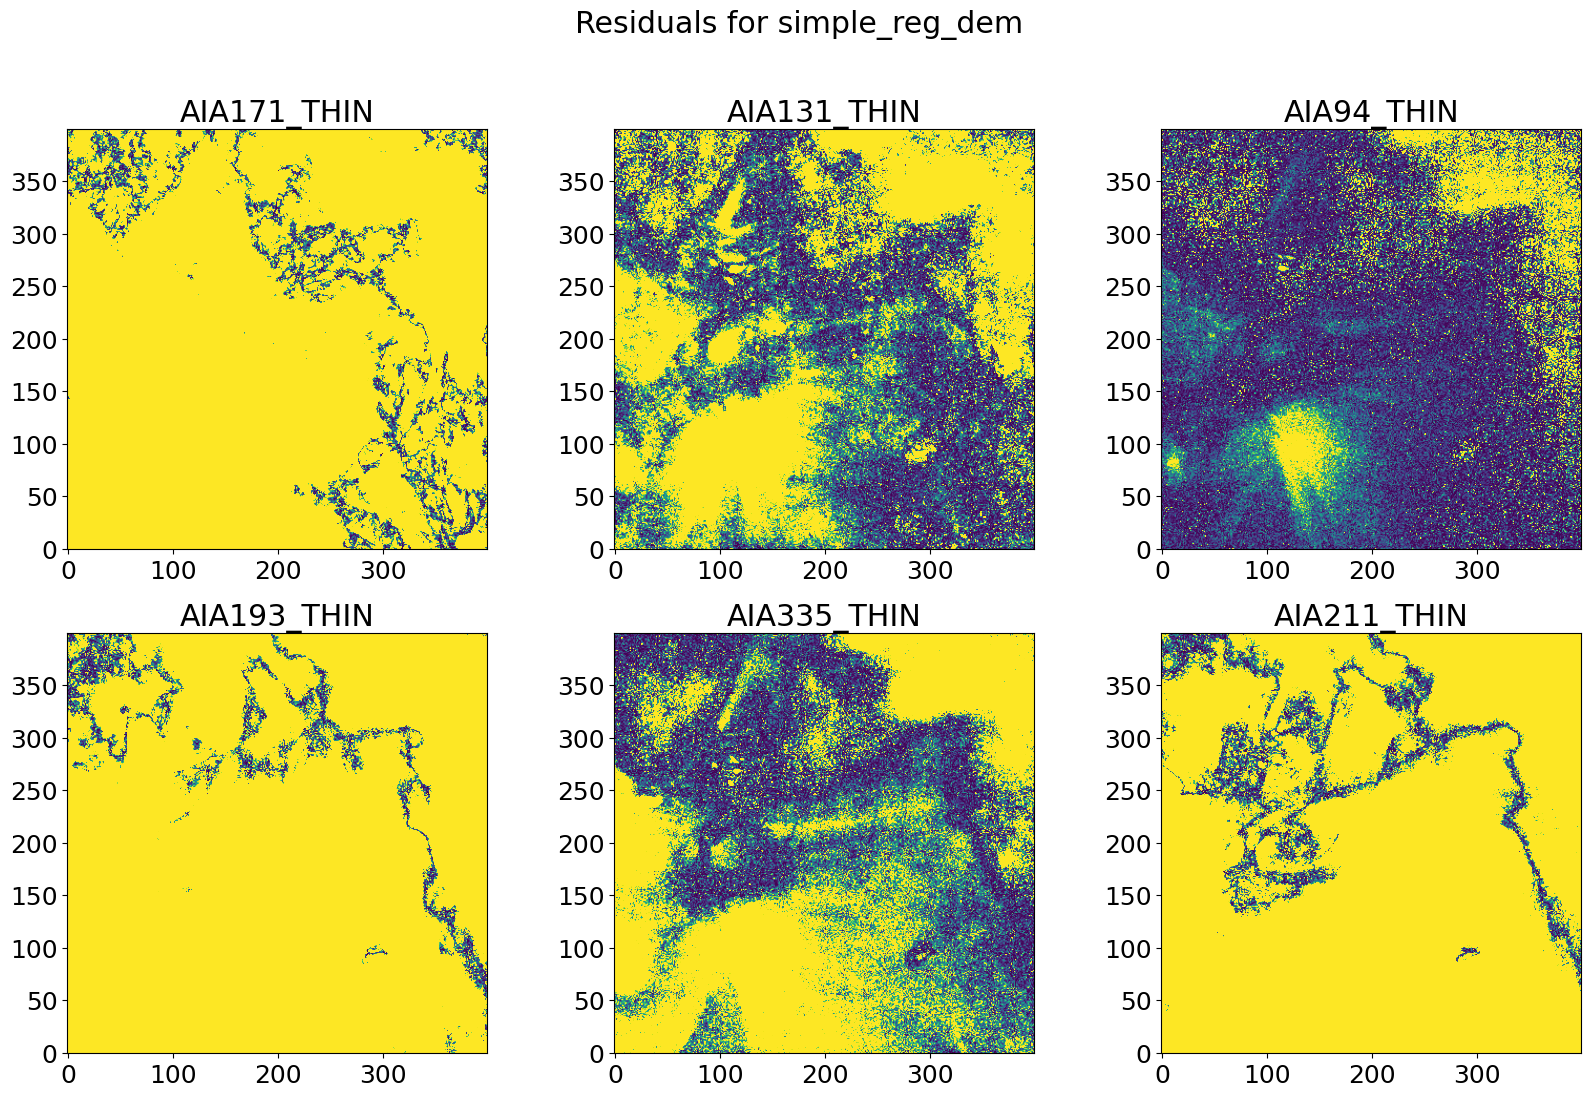

In [13]:
# Plot Residuals:
fig = plt.figure(figsize=[20,12])
plt.suptitle('Residuals for '+simpl_algorithm)
for i in range(0,6):
    ax1 = fig.add_subplot(2,3,i+1)
    ax1.imshow(simpl_resids[i],vmin=0,vmax=5)
    ax1.set(title=em_collection.data()[i].meta['channel'])

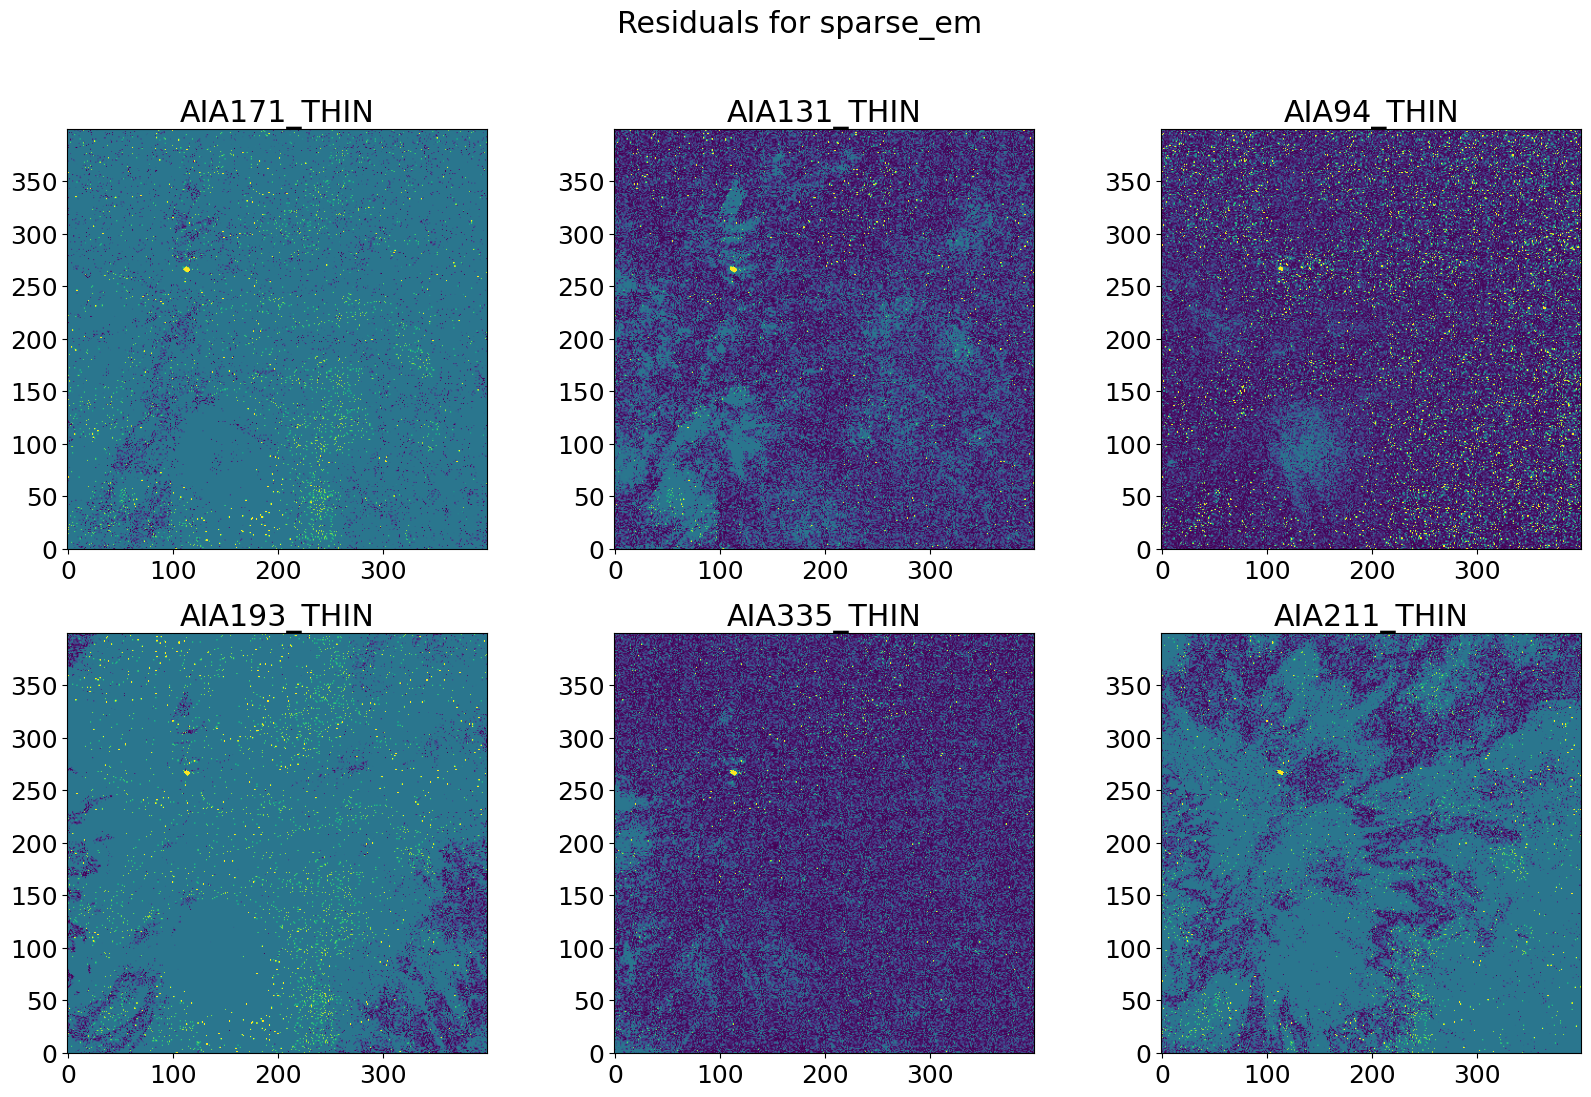

In [14]:
# Plot Residuals:
fig = plt.figure(figsize=[20,12])
plt.suptitle('Residuals for '+spars_algorithm)
for i in range(0,6):
    ax1 = fig.add_subplot(2,3,i+1)
    ax1.imshow(spars_resids[i],vmin=0,vmax=5)
    ax1.set(title=em_collection.data()[i].meta['channel'])

In [15]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


class dashboard_object(object):
    def __init__(self,em_collection):
        self.emc = em_collection

    def widgwrap(self, xpt, ypt, rtemp, gtemp, btemp, sigma, algorithm):
        dashboard_figure(self.emc, plotpoint=[xpt,ypt], temperatures=[rtemp,gtemp,btemp], sigmas=sigma, algorithm=algorithm)

In [16]:
dash = dashboard_object(em_collection)
[nx,ny] = dash.emc.collection[dash.emc.collection['models'][0]][0].data.shape

# Define the custom CSS
custom_css = """
<style>
.widget-readout {
    box-shadow: 0px 0px 1px 1px #a9a9a9 inset;
}
</style>
"""

# Display the custom CSS in the notebook
HTML(custom_css)

In [17]:
xpt=widgets.IntSlider(min=0, max=nx-1, value=10, step=1, description='xpt', continuous_update=True)
ypt=widgets.IntSlider(min=0, max=ny-1, value=100, step=1, description='ypt', continuous_update=True)
rtemp=widgets.FloatSlider(min=5, max=7, value=5.8, step=0.05, description='rtemp', continuous_update=False)
gtemp=widgets.FloatSlider(min=5, max=7, value=6.1, step=0.05, description='gtemp', continuous_update=False)
btemp=widgets.FloatSlider(min=5, max=7, value=6.4, step=0.05, description='btemp', continuous_update=False)
sigma=widgets.FloatSlider(min=0.025, max=0.5, value=0.125, step=0.01, description='sigma', continuous_update=False)
algorithm=widgets.Dropdown(options=dash.emc.collection['models'], description='algorithm', continuous_update=False)

ui = widgets.HBox([xpt,ypt,rtemp,gtemp,btemp,sigma,algorithm])
out = widgets.interactive_output(dash.widgwrap, {'xpt':xpt,'ypt':ypt,'rtemp':rtemp,'gtemp':gtemp,'btemp':btemp,'sigma':sigma,'algorithm':algorithm})

fig = plt.get_current_fig_manager().canvas.figure
print("Asdf")
def on_click(event):
    print(event)
    print(xpt, ypt)
    # fig.suptitle(f'x: {event.xdata}, y: {event.ydata}')
    # fig.canvas.draw_idle()
    if event.inaxes:
        xpt.value = int(event.xdata)
        ypt.value = int(event.ydata)
display(ui,out)
cid = fig.canvas.mpl_connect('button_press_event', on_click)
print("lolol")

Asdf


Output()

lolol


<Figure size 2700x1500 with 0 Axes>

In [18]:
emtot_synthdata = em_collection.synthesize_data(trlogts[0],1+0*trlogts[0],algorithm=simpl_algorithm)
emtemp_synthdata = em_collection.synthesize_data(trlogts[0],trlogts[0],algorithm=simpl_algorithm)
em_weighted_mean_temp = emtemp_synthdata[0].data/emtot_synthdata[0].data

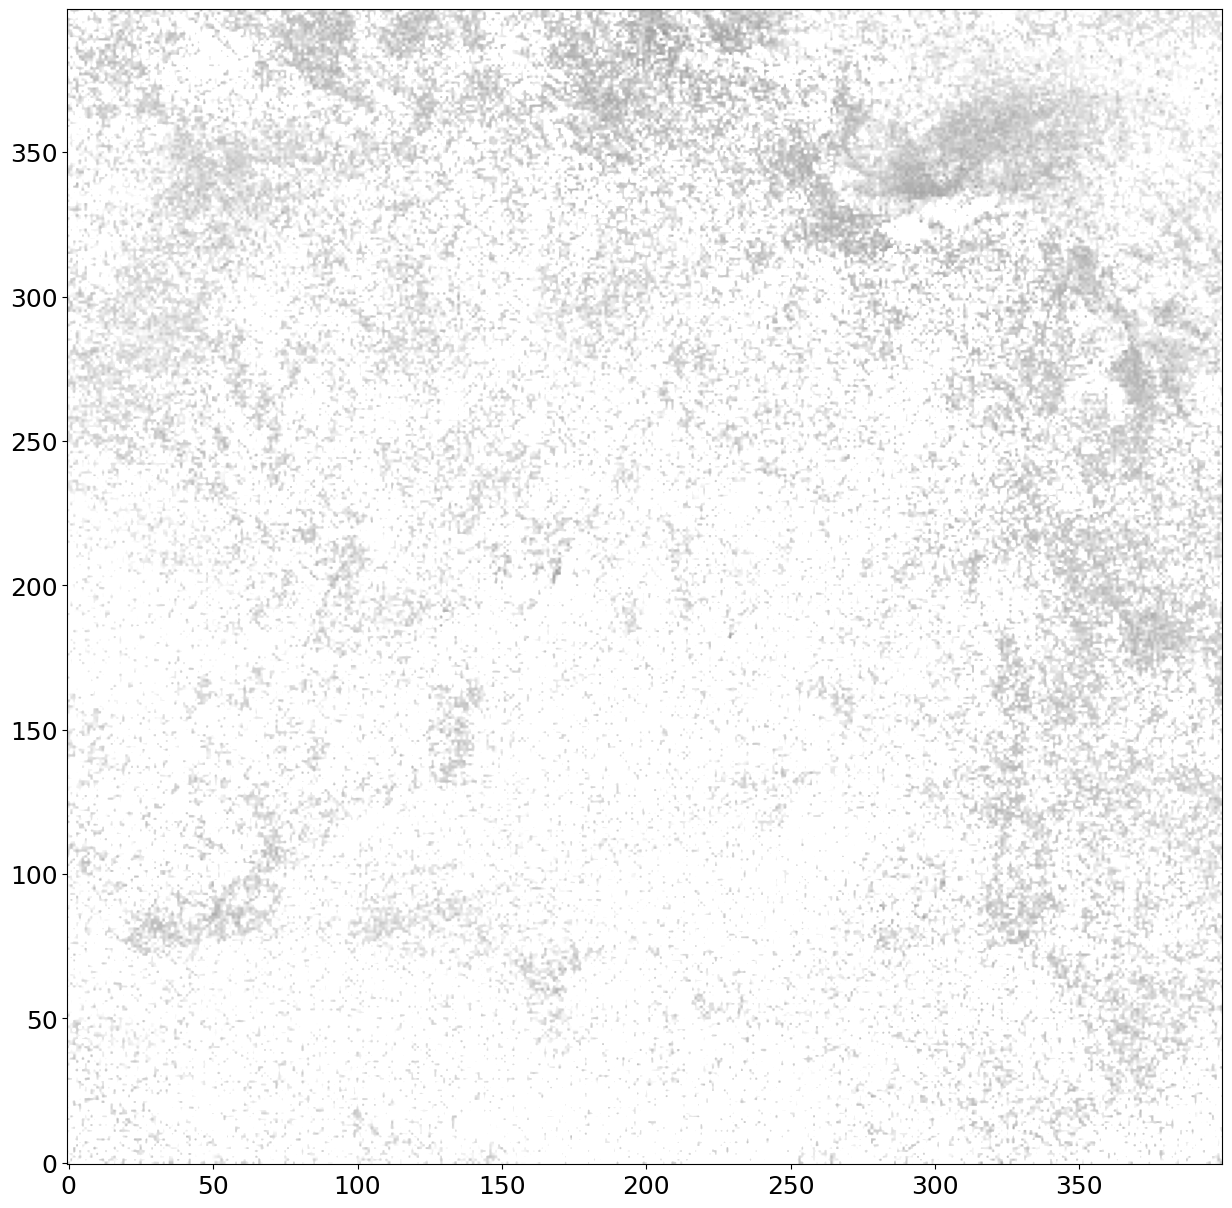

In [19]:
plt.imshow(em_weighted_mean_temp,vmin=5.5,vmax=6.5,cmap=plt.get_cmap('gray'))

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmod__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'capitalize',
 'casefold',
 'center',
 'count',
 'encode',
 'endswith',
 'expandtabs',
 'find',
 'format',
 'format_map',
 'index',
 'isalnum',
 'isalpha',
 'isascii',
 'isdecimal',
 'isdigit',
 'isidentifier',
 'islower',
 'isnumeric',
 'isprintable',
 'isspace',
 'istitle',
 'isupper',
 'join',
 'ljust',
 'lower',
 'lstrip',
 'maketrans',
 'partition',
 'removeprefix',
 'removesuffix',
 'replace',
 'rfind',
 'rindex',
 'rjust',
 'rpartition',
 'rsplit',
 'rstrip',
 'split',
 'splitlines',
 'startswith',
 'strip',
 'swapcase',


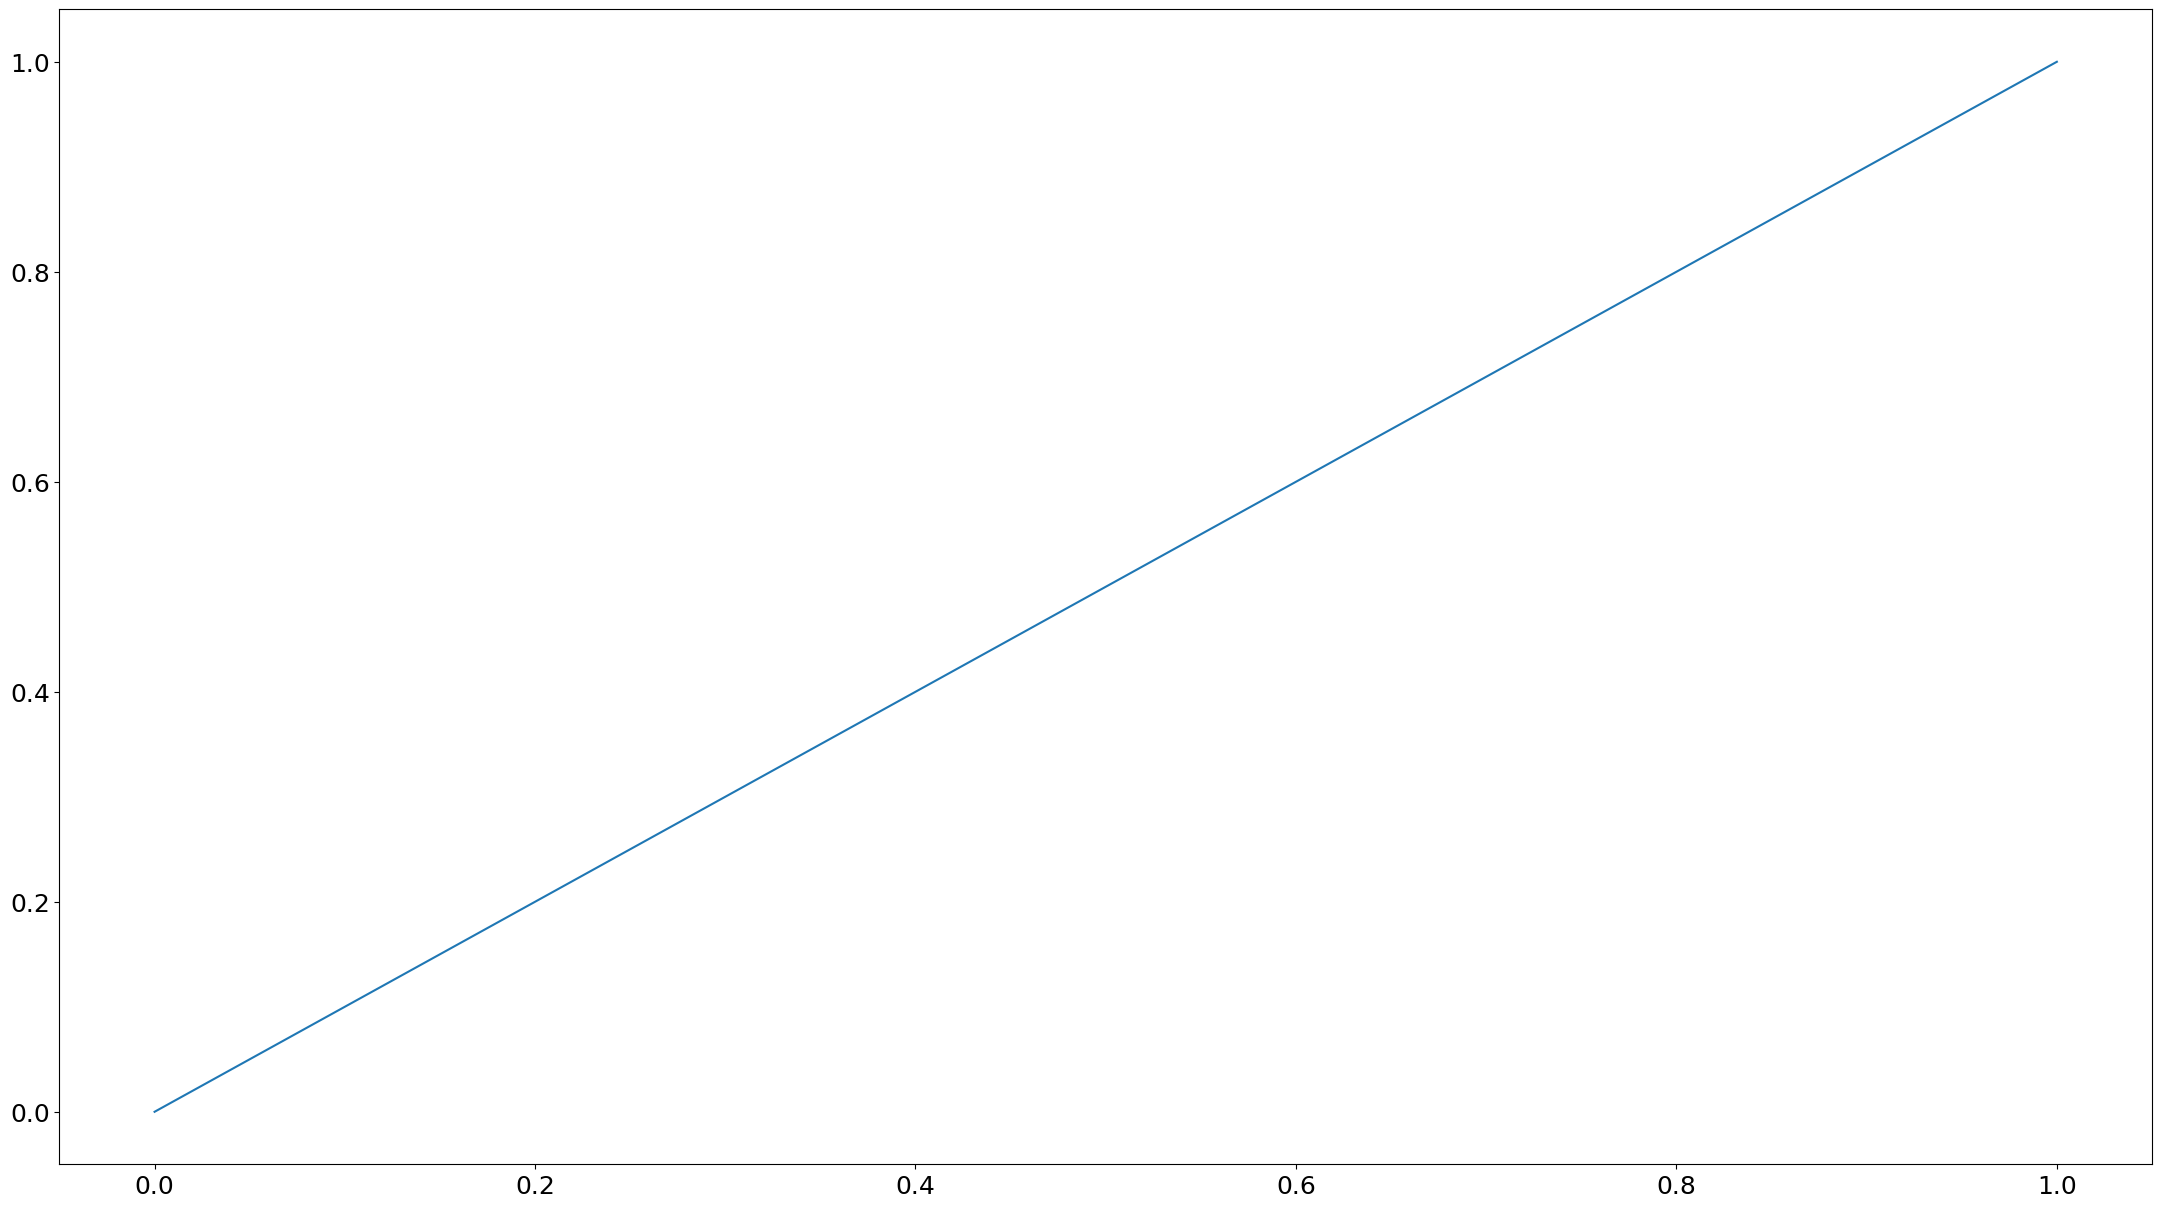

In [24]:
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Define a test click event handler
def on_click(event):
    print("Clicked at:", event.xdata, event.ydata)

# Create a figure and display it
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1])  # Example plot
plt.show()
# Connect the event handler
cid = fig.canvas.mpl_connect('button_press_event', on_click)
asdf = 2
